In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score, silhouette_score
import umap

c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Nonlinear dimensionality reduction

We'll work again with the PBMC dataset

In [2]:
pbmc = pd.read_csv('pbmc3k.csv.gz',index_col=0)

In [3]:
pbmc_normalized = np.log((pbmc.T/pbmc.sum(1)).T*1000000+1)

genes_to_keep = (pbmc_normalized > 0).sum() > 25
pbmc_filtered = pbmc_normalized[genes_to_keep.index[genes_to_keep]]
pbmc_filtered

,NOC2L,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,PUSL1,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1,PNRC2.1,SRSF10.1
AAACATACAACCAC-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.633497,6.025993,0.000000,8.326402,6.025993,0.0,7.410474,0.000000,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.000000,6.013504,0.0,0.000000,0.000000,0.0,0.0,0.0,...,8.026285,6.013504,0.000000,8.814564,5.322799,0.0,7.397962,5.322799,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,5.763814,0.000000,0.0,5.763814,0.000000,0.0,0.0,0.0,...,7.147752,0.000000,0.000000,6.860332,6.455391,0.0,7.147752,0.000000,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,8.134873,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.324309,0.000000,5.939991,7.036847,6.631821,0.0,6.631821,0.000000,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,6.927919,0.000000,0.000000,0.000000,7.620576,0.0,6.927919,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,0.0,8.305502,0.000000,0.0,0.000000,5.669653,0.0,0.0,0.0,...,7.746072,5.669653,0.000000,5.669653,0.000000,0.0,5.669653,0.000000,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,5.673692,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.616653,0.000000,5.673692,6.365120,5.673692,0.0,7.057407,0.000000,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,8.332734,0.000000,0.000000,8.332734,0.000000,0.0,7.773299,0.000000,0.0,0.0
TTTGCATGAGAGGC-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,7.577698,0.000000,6.885062,0.000000,0.000000,0.0,6.885062,0.000000,0.0,0.0


## PCA
We're going to compare our results with PCA, so first we'll recompute stuff from last lecture

In [4]:
pbmc_filtered_centered = pbmc_filtered.apply(lambda x: x-x.mean())
U,s,Vt = np.linalg.svd(pbmc_filtered_centered,full_matrices=False)

In [5]:
PVE = s**2/(s**2).sum()
num_pcs = np.where(PVE.cumsum() > 0.3)[0][0]+1
X_PCA = U[:,:num_pcs].dot(np.diag(s[:num_pcs]))
num_pcs

np.int64(243)

## Kernel PCA

We'll start with the gaussian kernel

In [6]:
dist_high = distance.pdist(pbmc_filtered,'euclidean')

In [7]:
sigma = 250
K = np.exp(-dist_high**2/(2*sigma**2))
K = distance.squareform(K)
#K = pbmc_filtered.dot(pbmc_filtered.T)
K.shape

(2700, 2700)

In [10]:
K_centered = K - K.mean(0)
K_centered = K_centered.T - K.mean(1)
K_centered += K.mean()

In [11]:
U_k,s_k,Vt_k = np.linalg.svd(K_centered)

In [12]:
PVE_k = s_k**2/(s_k**2).sum()
num_kpcs = np.where(PVE_k.cumsum() > 0.4)[0][0] + 1
A = np.diag(s_k[:num_kpcs]).dot(Vt_k[:num_kpcs])
X_KPCA = A.dot(K).T
num_kpcs

np.int64(301)

## Distribution of distances

In [13]:
dist_pca = distance.pdist(X_PCA,'euclidean')
dist_kpca = distance.pdist(X_KPCA,'euclidean')

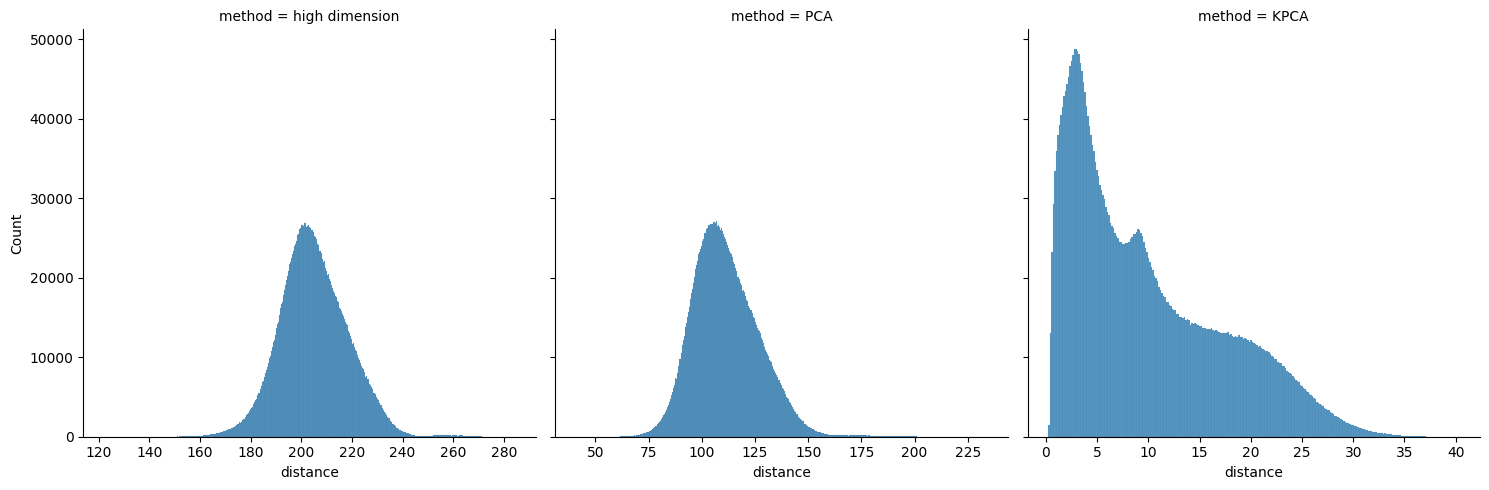

In [14]:
df_distance = pd.concat([pd.DataFrame({'distance': dist_high, 'method': ['high dimension']*len(dist_high)}),
                         pd.DataFrame({'distance': dist_pca, 'method': ['PCA']*len(dist_pca)}),
                         pd.DataFrame({'distance': dist_kpca, 'method': ['KPCA']*len(dist_kpca)})])

sns.displot(df_distance,kind='hist',x='distance',col='method',col_wrap=3,common_norm=False, common_bins=False,facet_kws={'sharex':False})

## Distortion
Now let's compare distortion of high dimensional distances in each embedding

In [15]:
distance_correlations = 1 - distance.squareform(distance.pdist([dist_high, dist_pca, dist_kpca],'correlation'))
labels = ['high dimension', 'PCA', 'K-PCA']
distance_correlations = pd.DataFrame(distance_correlations, columns=labels, index=labels)
distance_correlations

,high dimension,PCA,K-PCA
high dimension,1.000000,0.918419,0.510689
PCA,0.918419,1.000000,0.671260
K-PCA,0.510689,0.671260,1.000000


## Clustering
Next evaluate differences in clustering

In [16]:
clust_high = KMeans(n_clusters=12).fit(pbmc_filtered).labels_
clust_pca = KMeans(n_clusters=12).fit(X_PCA).labels_
clust_kpca = KMeans(n_clusters=12).fit(X_KPCA).labels_

In [17]:
MI = np.eye(3)
MI[0,1] = adjusted_mutual_info_score(clust_high,clust_pca)
MI[0,2] = adjusted_mutual_info_score(clust_high,clust_kpca)
MI[1,2] = adjusted_mutual_info_score(clust_pca,clust_kpca)
MI = pd.DataFrame(MI, columns=labels, index=labels)
MI

,high dimension,PCA,K-PCA
high dimension,1.0,0.670585,0.537402
PCA,0.0,1.000000,0.607767
K-PCA,0.0,0.000000,1.000000


In [18]:
ss_high = silhouette_score(distance.squareform(dist_high),clust_high,metric='precomputed')
ss_pca = silhouette_score(distance.squareform(dist_pca),clust_pca,metric='precomputed')
ss_kpca = silhouette_score(distance.squareform(dist_kpca),clust_kpca,metric='precomputed')
ss_high, ss_pca, ss_kpca

(np.float64(-0.008558387396747445),
 np.float64(0.0031913010142142462),
 np.float64(0.3994910941538828))

## Visualizations

<Axes: >

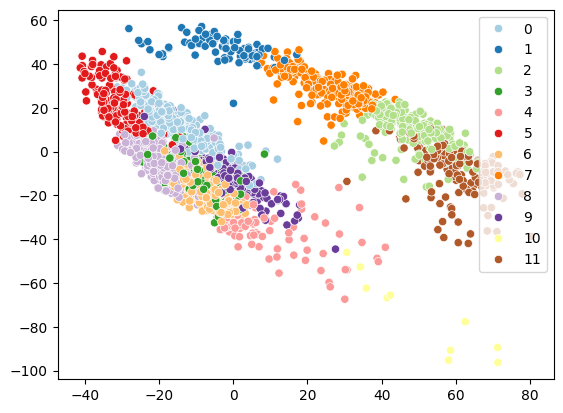

In [19]:
#sns.scatterplot(x=X_PCA[:,0], y=X_PCA[:,1], hue=pbmc_filtered['GNLY'])
#sns.scatterplot(x=X_PCA[:,2], y=X_PCA[:,3], hue=pbmc_filtered['NKG7'])
sns.scatterplot(x=X_PCA[:,0], y=X_PCA[:,1], hue=clust_pca, palette='Paired')

<Axes: >

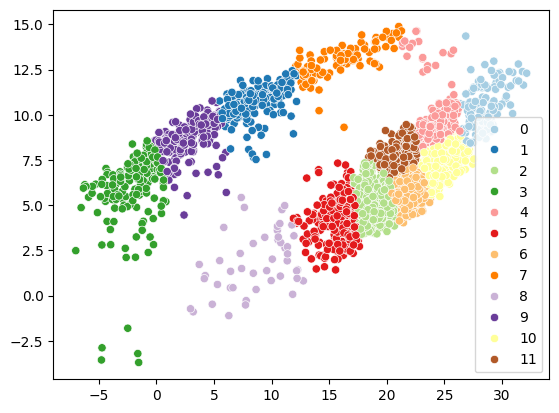

In [20]:
#sns.scatterplot(x=X_KPCA[:,0], y=X_KPCA[:,1], hue=pbmc_filtered['GNLY'])
#sns.scatterplot(x=X_KPCA[:,2], y=X_KPCA[:,3], hue=pbmc_filtered['NKG7'])
sns.scatterplot(x=X_KPCA[:,0], y=X_KPCA[:,1], hue=clust_kpca, palette='Paired')

c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


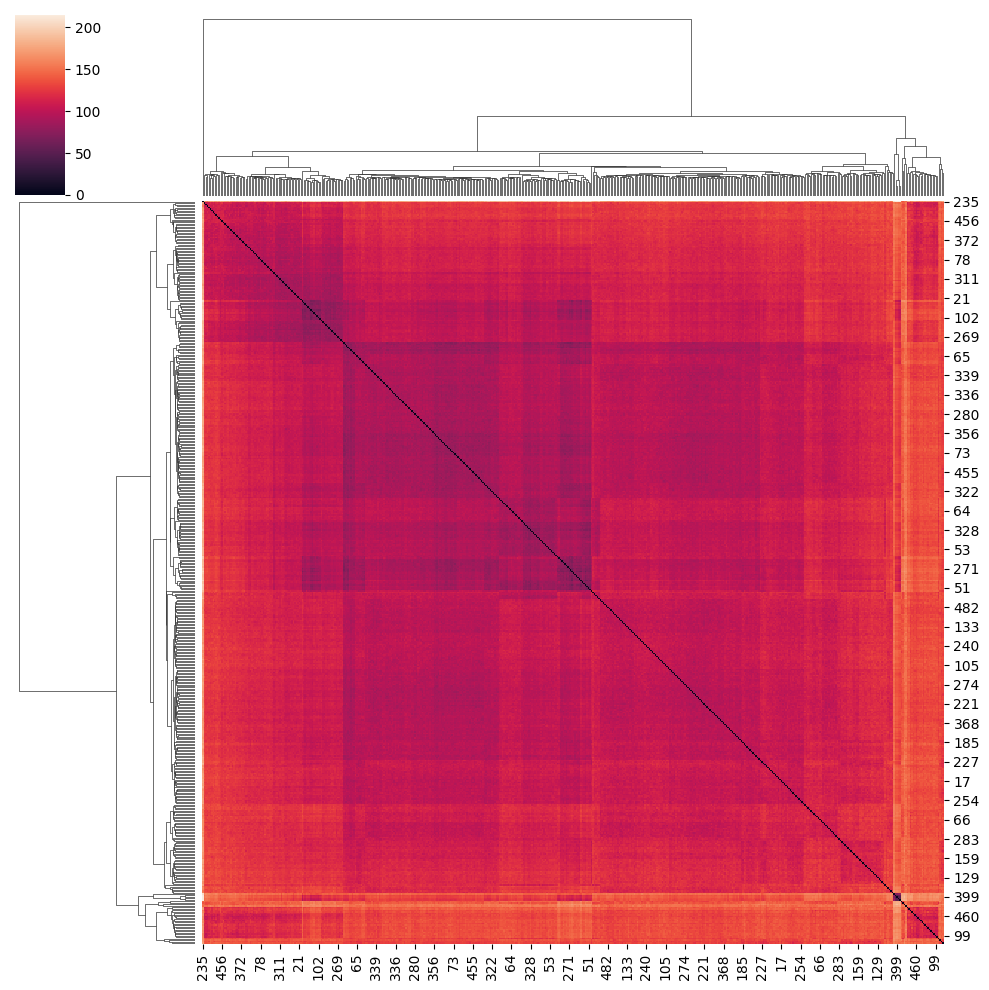

In [21]:
idx = np.random.choice(pbmc.shape[0],500,replace=False)
D_pca = distance.squareform(dist_pca)
sns.clustermap(D_pca[idx][:,idx])

c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


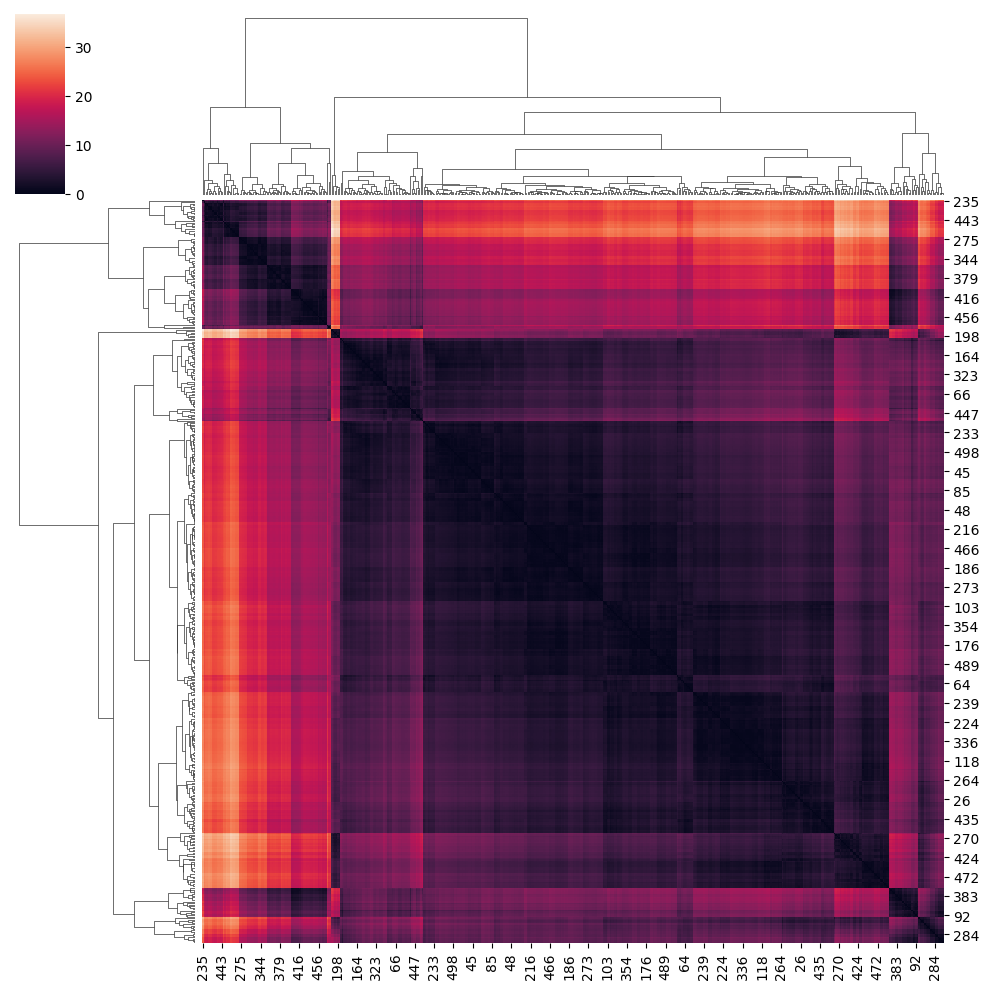

In [22]:
D_kpca = distance.squareform(dist_kpca)
sns.clustermap(D_kpca[idx][:,idx])

c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


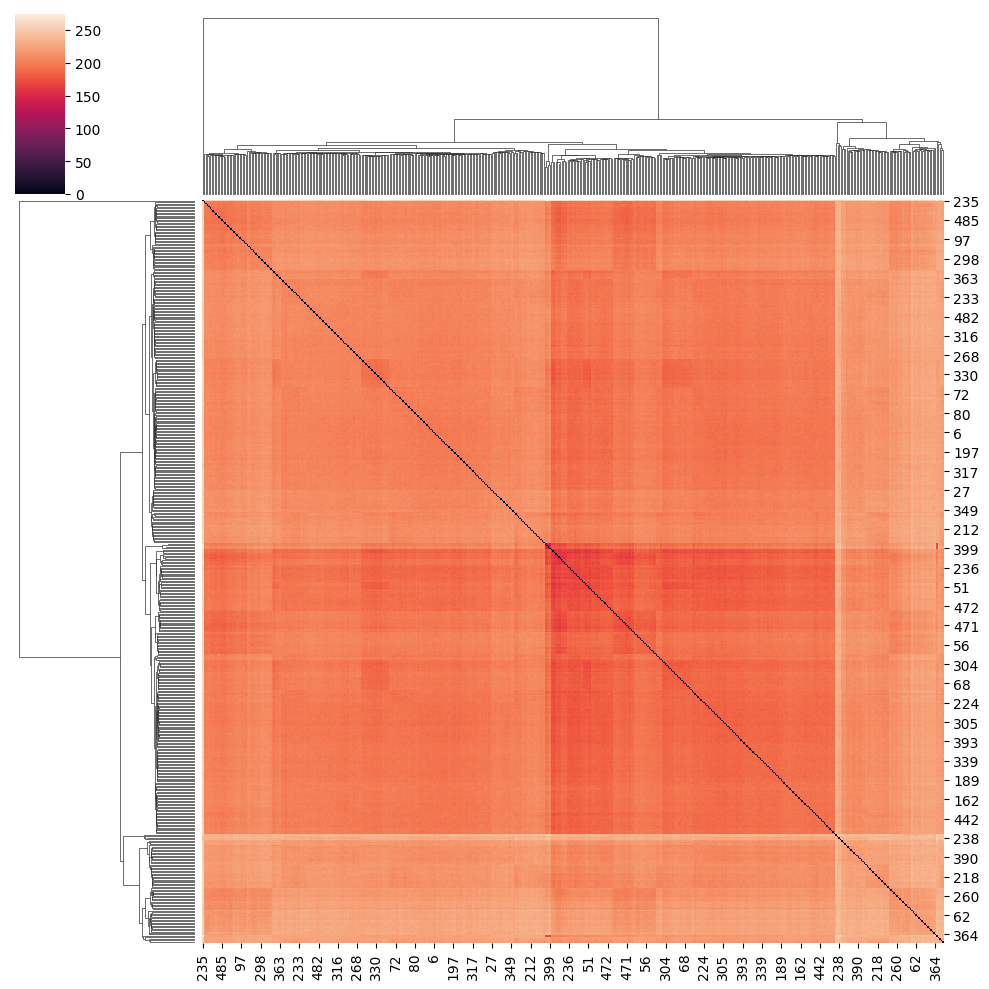

In [23]:
D_high = distance.squareform(dist_high)
sns.clustermap(D_high[idx][:,idx])

## UMAP
We'll play around with several hyperparameters that can have a significant effect on UMAP embedding. See [here](https://umap-learn.readthedocs.io/en/latest/parameters.html) for discussion of these parameters. 

In [24]:
reducer = umap.UMAP(metric='euclidean', min_dist=0.5, n_neighbors=200)
embedding_pca = reducer.fit_transform(X_PCA)
embedding_kpca = reducer.fit_transform(X_KPCA)

c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

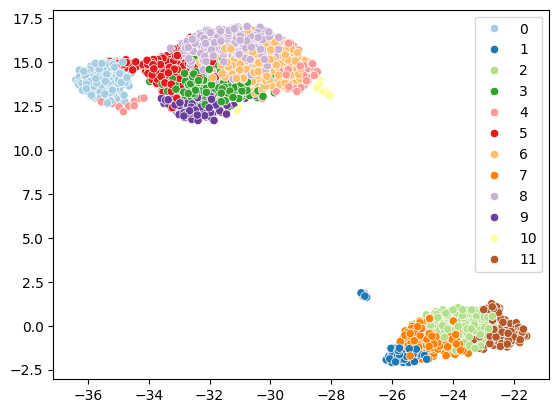

In [25]:
sns.scatterplot(x=embedding_pca[:,0], y=embedding_pca[:,1], hue=clust_pca, palette='Paired')

<Axes: >

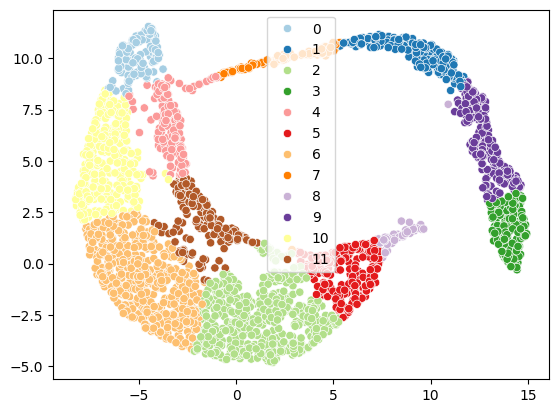

In [26]:
sns.scatterplot(x=embedding_kpca[:,0], y=embedding_kpca[:,1], hue=clust_kpca,palette='Paired')